<a href="https://colab.research.google.com/github/svtuck/rankings/blob/master/rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start by going in the order that USA ultimate presents the algorithm here: https://play.usaultimate.org/teams/events/rankings/

Up first is defining the score differential function.

In [0]:
import math
from collections import namedtuple

GameScore = namedtuple('GameScore', ['winning', 'losing'])
sin_p_four_pi = math.sin(.4 * math.pi)
def game_score_differential(score: GameScore) -> float:
	r = score.losing / (score.winning - 1)
	differential = 125 + 475 * math.sin(min(1, (1 - r) / .5) * .4 * math.pi) / sin_p_four_pi
	return differential

Let's spot check it. I'm assuming the round is applied AFTER the score, for the purposes of presenting the example table.

In [0]:
assert round(game_score_differential(GameScore(15, 14))) == 125
assert round(game_score_differential(GameScore(15, 5))) == 600
assert round(game_score_differential(GameScore(15, 11))) == 381
assert round(game_score_differential(GameScore(13, 9))) == 419
assert round(game_score_differential(GameScore(13, 7))) == 558
assert round(game_score_differential(GameScore(11, 9))) == 249
assert round(game_score_differential(GameScore(11, 6))) == 547

Next we define the "score weight". 

In [0]:
def score_weight(score: GameScore) -> float:
  return min(1, math.sqrt((score.winning + max(score.losing, (score.winning - 1) / 2)) / 19))

assert round(score_weight(GameScore(13,0)), 2) == 1.0
assert round(score_weight(GameScore(1,0)), 2) == .23
assert round(score_weight(GameScore(11,3)), 2) == .92
assert round(score_weight(GameScore(12,6)), 2) == .97


This looks okay, but I see at least one difference between my function and the published table, I'm going to chalk this up to rounding somewhere...

In [4]:
print(round(score_weight(GameScore(8,2)), 2) - .76)

0.020000000000000018


Finally, we need to interpret this: "The date weight depends upon how recently the game was played; games in the first week of the regular season will get a date weight of 0.5, while games in the last week of the season get a date weight of 1.0. Date weights of games in intermediate weeks are interpolated exponentially, so each week's date weight is a fixed multiple of the previous week's date weight."

There is no published formula here, so I will interpret it as best I can. If we have played N weeks, then week 1 gets a weight of .5, week N gets a weight of 1.0 and week m < N gets a weight of Nth root of 2.

.5 * factor ^ m = .5

.5 * factor ^ N = 1

factor^ N = 2 

factor = 2 ^ (1/N)

In [0]:
#Defining this constant outside, we will set this appropriately later
NUM_WEEKS = 10

def get_weighting_function():
  factor = pow(2, 1/(NUM_WEEKS - 1))
  return lambda m: .5 * pow(factor, m - 1)


assert round(get_weighting_function()(1), 2) == .5
assert round(get_weighting_function()(10), 2) == 1
NUM_WEEKS = 3
assert round(get_weighting_function()(1), 2) == .5
assert round(get_weighting_function()(3), 2) == 1

#Weights are constant factors between weeks
NUM_WEEKS = 10
assert round(get_weighting_function()(5)/get_weighting_function()(4), 2) == round(get_weighting_function()(8)/get_weighting_function()(7), 2)

Collect all calculations that are not dependent on actual ratings.

In [0]:
WeightedScore = namedtuple("WeightedScore", ['differential', 'score_weight', 'date_weight'])

def weight_score(score: GameScore, week_number: int) -> WeightedScore:
  differential = game_score_differential(score)
  s = score_weight(score)
  d = get_weighting_function()(week_number)
  return WeightedScore(round(differential), round(s,3), round(d,3))

Now we have our scoring functions defined, and we can move on to read in our data, downloaded from https://www.usaultimate.org/college/#Rankings



In [7]:
import csv
games = []

# We will use "ids" and map back when we display something
name_dictionary = {}
with open('games.csv') as csvfile:
  game_reader = csv.DictReader(csvfile)
  for row in game_reader:
    try:
      team_1_score = int(row['Team 1 Score'])
      team_2_score = int(row['Team 2 Score'])
      games.append(row)
      name_dictionary[row['Team 1 ID']] = row['School Name 1+Team Designation']
      name_dictionary[row['Team 2 ID']] = row['School Name 2+Team Designation']
    except ValueError as e:
      pass

print(len(games), len(name_dictionary.keys()))

2702 428


Now we can precalculate weights and differentials

In [8]:
from collections import defaultdict
from datetime import datetime
from dateutil.parser import parse

start_date = datetime.max
end_date = datetime.min
for game in games:
  d = parse(game['Game Date'])
  if d < start_date:
    start_date = d
  if d > end_date:
    end_date = d

NUM_WEEKS = int((end_date - start_date).days / 7 + 1)


def games_to_scores(games):
  weighted_scores = defaultdict(list)
  for game in games:
    try: 
      #We are calling the first week, 'week 1'
      week_number =  int((parse(game['Game Date']) - start_date).days / 7 + 1)
      team_1_score = int(game['Team 1 Score'])
      team_2_score = int(game['Team 2 Score'])

      score = GameScore(max(team_1_score, team_2_score), min(team_1_score, team_2_score))
      weights = weight_score(score, week_number)
      loser_weights = WeightedScore(-1 * weights.differential , weights.score_weight, weights.date_weight)
      if (team_1_score >= team_2_score):
        winner = game['Team 1 ID']
        loser = game['Team 2 ID']
      else:
        winner = game['Team 2 ID']
        loser = game['Team 1 ID']

      weighted_scores[winner].append((weights, loser))
      weighted_scores[loser].append((loser_weights, winner))

    except ValueError as e:
      # Throw out L/W/F... no defined way of handling them
      pass
  return weighted_scores
weighted_scores = games_to_scores(games)
print(len(weighted_scores))  



428


Let's spot check some, say: Oregon (19693), and Puget Sound (20039) and verify that all differentials sum to 0.

In [9]:

print(sum(x[0].differential > 0 for x in weighted_scores["19693"]), sum(x[0].differential < 0 for x in weighted_scores["19693"]))
print(sum(x[0].differential > 0 for x in weighted_scores["20039"]), sum(x[0].differential < 0 for x in weighted_scores["20039"]))

14 5
12 4


In [0]:
assert sum([x[0].differential for i in weighted_scores for x in weighted_scores[i] ]) == 0

Now let's run the the rankings

In [11]:
def new_rating(team_id, ratings, scores):
  s = scores[team_id]
  numerator = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s]
  denominator = [weights.score_weight * weights.date_weight for (weights, _) in s]
  return sum(numerator) / sum(denominator)

def rank(scores):
  
  ratings = {i: 1000 for i in scores}
  for r in range(100):
    new_ratings = {i: new_rating(i, ratings, scores) for i in ratings.keys()}
    ratings = new_ratings
  return ratings

def top_n(n, ratings):
  return sorted([(ratings[i], name_dictionary[i]) for i in ratings], reverse=True)[:n]

def print_top_n(n, ratings):
  t = top_n(n, ratings)
  for x in t:
    print(x[1], round(x[0]))
    



print_top_n(20, rank(weighted_scores))

  

Brown 2065
North Carolina 2050
Oregon 2027
Pittsburgh 2024
Cal Poly-SLO 1972
Brigham Young 1968
Carleton College-CUT 1961
Colorado 1937
Massachusetts 1905
North Carolina State 1878
Washington 1869
Wisconsin 1862
Southern California 1848
Texas 1835
Ohio State 1834
Central Florida 1828
Minnesota 1795
Michigan 1740
Tufts 1737
Colorado State 1735


Looks about right. There are a couple of special edge cases I haven't included, but I think this is safe to call a correct implementation of the algorithm. Now let's try to evaluate it.

First lets look at distribution of ratings.


(array([ 2.,  1.,  5.,  8., 10., 20., 26., 45., 36., 38., 48., 44., 32.,
        34., 25., 18., 15.,  5.,  9.,  7.]),
 array([-475.16775281, -348.17608286, -221.18441291,  -94.19274297,
          32.79892698,  159.79059693,  286.78226688,  413.77393683,
         540.76560677,  667.75727672,  794.74894667,  921.74061662,
        1048.73228656, 1175.72395651, 1302.71562646, 1429.70729641,
        1556.69896635, 1683.6906363 , 1810.68230625, 1937.6739762 ,
        2064.66564615]),
 <a list of 20 Patch objects>)

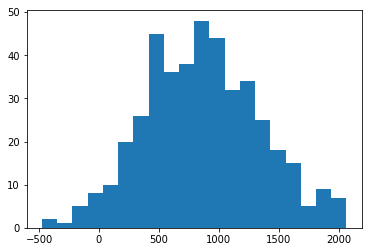

In [12]:
import matplotlib.pyplot as plt
ratings = rank(weighted_scores)
plt.hist([ratings[i] for i in ratings], bins=20)

That jives with what we would expect. Next lets explore how predictive the ratings are. To do this, we'll train a logistic regression model on the rating differentials and results.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


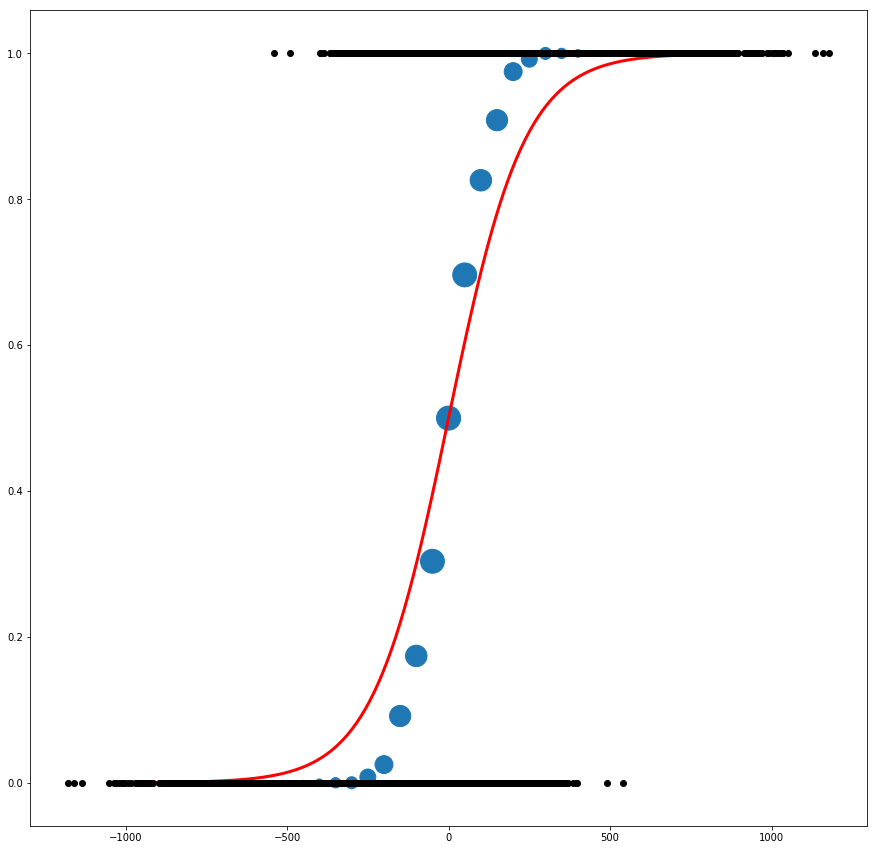

In [13]:
from sklearn import linear_model
import numpy as np

def viz_differentials(ratings, scores):
  rating_differentials = []
  results = []
  for team in scores:
    for game in scores[team]:
      results.append( 1 if game[0].differential > 0 else 0)
      rating_differentials.append(ratings[team] - ratings[game[1]])
  X = np.reshape(rating_differentials, (-1, 1))
  y = np.reshape(results, (-1, 1))
  clf = linear_model.LogisticRegression(solver='lbfgs')
  clf.fit(X, y)
  plt.figure(1, figsize=(15, 15))
  plt.clf()
  plt.scatter(X.ravel(), y, color='black', zorder=20)
  X_test = np.linspace(-1000, 1000, 300)
  def model(x):
    return 1 / (1 + np.exp(-x))

  loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
  plt.plot(X_test, loss, color='red', linewidth=3)

  binned = defaultdict(list)
  for (differential, result) in zip(rating_differentials, results):
    binned[50 * round(differential/100)].append(result)
  x = []
  y = []
  area = []
  for i in binned:
    x.append(i)
    y.append(sum(binned[i])/len(binned[i]))
    area.append(len(binned[i]))
  plt.scatter(x,y,s=area)


def explore(scores):
  ratings = rank(scores)
  viz_differentials(ratings, scores)
  
      
explore(weighted_scores)
    
  

So we have reasonably confident (>80%) predictions when ratings are more than about 100 points different. Finally, I wanted to run a cross validation on the algorithm. To do that, we with withhold 10% of games, rerank, and then use the resulting rankings to predict the winners of the held out games.

In [14]:
import random

def evaluate(games):
  random.shuffle(games)
  sample_size = int(len(games) / 10)
  test = games[:sample_size]
  train = games[sample_size:]
  
  scores = games_to_scores(train)
  ranks = rank(scores)
  avg = sum([ranks[i] for i in ranks])/len(ranks)

  results = [(ranks.get(game['Team 1 ID'], avg) > ranks.get(game['Team 2 ID'], avg)) == (int(game['Team 1 Score']) > int(game['Team 2 Score'])) for game in test]
  return sum(results)/len(results)


results = [evaluate(games) for i in range(3)]
print(results)
print(sum(results)/len(results))

[0.7777777777777778, 0.7703703703703704, 0.7814814814814814]
0.7765432098765433


We are looking at roughly 25% of all games as upsets according to our algorithm. It'd be interesting to know if this is better or worse at the top. So we will repeat this but only evaluate against the top 10% of teams.



In [15]:
def evaluate_top_k(games, k):
  random.shuffle(games)
  sample_size = int(len(games) / 10)
  test = games[:sample_size]
  train = games[sample_size:]
  
  scores = games_to_scores(train)
  ranks = rank(scores)
  
  avg = sum([ranks[i] for i in ranks])/len(ranks)
  threshold = sorted([ranks[i] for i in ranks])[int(len(ranks)* k)]
  
  top_games = list(filter(lambda game: (ranks.get(game['Team 1 ID'], avg) > threshold and ranks.get(game['Team 2 ID'], avg) > threshold), test))
  results = [(ranks.get(game['Team 1 ID'], avg) > ranks.get(game['Team 2 ID'], avg)) == (int(game['Team 1 Score']) > int(game['Team 2 Score'])) for game in top_games]
  return sum(results)/len(results)


results = [evaluate_top_k(games, .9) for i in range(3)]
print(results)
print(sum(results)/len(results))

[0.6923076923076923, 0.7037037037037037, 0.7142857142857143]
0.7034323700990367


This says that pure rankings are perhaps a little worse at the top than they are in the entire population, but only slightly and not confidently.

Finally let's look at that slice of data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


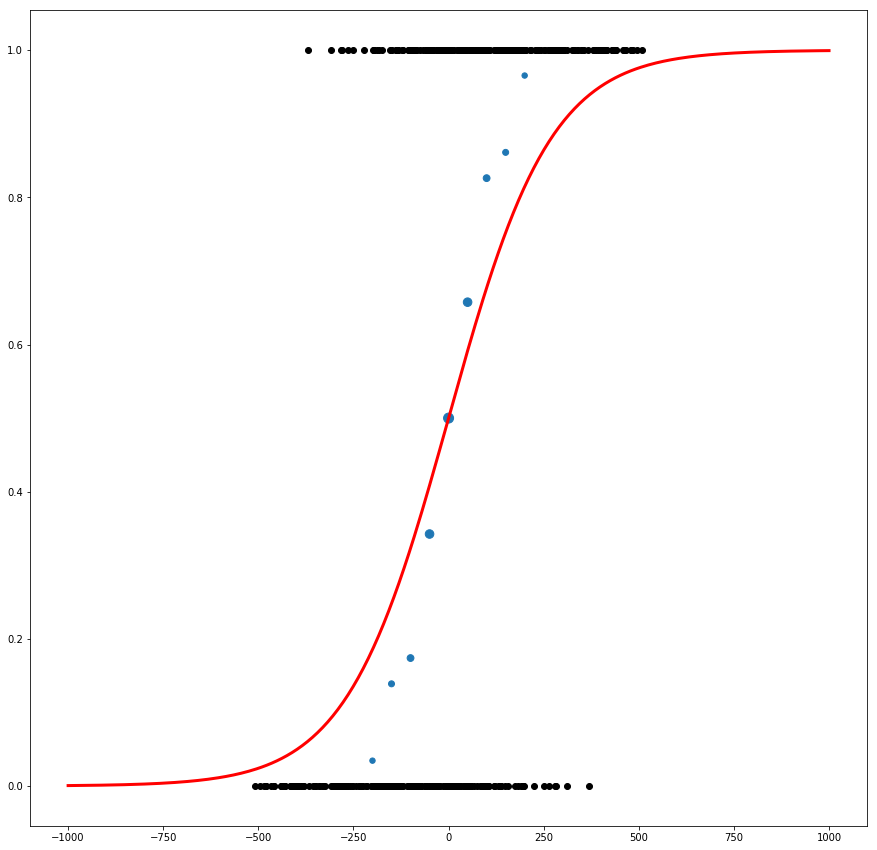

In [16]:
def explore_top(scores):
  ratings = rank(scores)

  threshold = sorted([ratings[i] for i in ratings])[int(len(ratings)* .9)]
  top_games = defaultdict(list)
  for team in scores:
    if ratings[team] > threshold:
      for game in scores[team]:
        if ratings[game[1]] > threshold:
          top_games[team].append(game)
    
  viz_differentials(ratings, top_games)
explore_top(weighted_scores)

In [17]:
def contribs(team_id, ratings, scores):
  s = scores[team_id]
  wins = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s if weights.differential > 0]
  losses = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s if weights.differential <= 0]
  numerator = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s]
  
  wins_denominator = [weights.score_weight * weights.date_weight for (weights, _) in s if weights.differential > 0]
  
  denominator = [weights.score_weight * weights.date_weight for (weights, _) in s ]

  pts_from_win = sum(wins)/sum(denominator)
  return pts_from_win / ratings[team_id]

def contribs_play_up(team_id, ratings, scores):
  s = scores[team_id]
  wins = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s if ratings[opponent_id] < ratings[team_id]]
  losses = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s if weights.differential <= 0]
  numerator = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in s]
  
  wins_denominator = [weights.score_weight * weights.date_weight for (weights, _) in s if weights.differential > 0]
  
  denominator = [weights.score_weight * weights.date_weight for (weights, _) in s ]

  pts_from_win = sum(wins)/sum(denominator)
  return pts_from_win / ratings[team_id]

ratings = rank(weighted_scores)
c = sorted([(contribs_play_up(t, ratings, weighted_scores), ratings[t], name_dictionary[t]) for t in ratings])
for t in c:
  if(t[1] > 1700):
    print(t)

  

(0.5128888451543159, 1737.246357104353, 'Tufts')
(0.5309759747199394, 1833.9616353344918, 'Ohio State')
(0.6234552971866283, 1834.7723569155642, 'Texas')
(0.6271329268350349, 1734.9079155393983, 'Colorado State')
(0.651873125968006, 1960.8240079136378, 'Carleton College-CUT')
(0.6669171752405064, 1795.4210182539375, 'Minnesota')
(0.6979474289606733, 1828.0785011476976, 'Central Florida')
(0.7310002923162585, 1868.5523690194107, 'Washington')
(0.7324813989968558, 1905.4655595015804, 'Massachusetts')
(0.7633802931193004, 1936.925593055036, 'Colorado')
(0.7747915291757058, 1862.0578309372556, 'Wisconsin')
(0.7804413409438015, 1877.9463200878808, 'North Carolina State')
(0.8158887719876639, 1967.50572483209, 'Brigham Young')
(0.8458436415011462, 1848.3004284832004, 'Southern California')
(0.8781435612198681, 1972.454323692527, 'Cal Poly-SLO')
(0.8876385923464437, 2023.956770325937, 'Pittsburgh')
(0.9025823367831051, 2049.7007612742955, 'North Carolina')
(1.0000000826807809, 1739.6060849204

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(428,) (428,)
Difference in win rate, Actual Wins, Expected wins
((-0.10524622400659311, 12, 14.315416928145048), 'Minnesota')
((-0.09271937001967845, 10, 11.854387400393568), 'Colorado State')
((-0.08352883132169353, 14, 15.587047795112177), 'Oregon')
((-0.0783557953634284, 13, 14.567115907268569), 'Washington')
((-0.0702948354049161, 17, 18.546486378908153), 'Pittsburgh')
((-0.06498835121426483, 12, 13.169790321856766), 'Colorado')
((-0.06288799111126275, 13, 14.32064781333652), 'Carleton College-CUT')
((-0.059888728082088005, 14, 15.077997105477584), 'Southern California')
((-0.046696291382847366, 18, 19.167407284571183), 'North Carolina State')
((-0.03627125636314077, 14, 14.725425127262815), 'Wisconsin')
((-0.03143168638758509, 10, 10.628633727751701), 'Tufts')
((-0.017458070769816092, 18, 18.366619486166137), 'Michigan')
((-0.004836374404927235, 9, 9.072545616073908), 'Ohio State')
((0.027278678911093035, 22, 21.29075434831158), 'Cal Poly-SLO')
((0.03879534380194971, 23, 22.03011

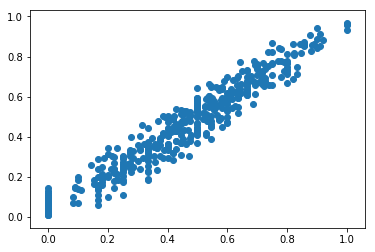

In [18]:
def wins_vs_expected(ratings, scores):
  rating_differentials = []
  results = []
  for team in scores:
    for game in scores[team]:
      results.append( 1 if game[0].differential > 0 else 0)
      rating_differentials.append(ratings[team] - ratings[game[1]])
  X = np.reshape(rating_differentials, (-1, 1))
  y = np.reshape(results, (-1, 1))
  clf = linear_model.LogisticRegression(solver='lbfgs')
  clf.fit(X, y)
  w,g,e = [],[],[]
  diffs = {}
  for team in scores:
    wins = 0
    games = 0
    expected_wins = 0
    for game in scores[team]:
      diff = ratings[team] - ratings[game[1]]
      expected_wins += clf.predict_proba(np.reshape([diff], (-1, 1)))[0][1]
      games += 1
      wins += 1 if game[0].differential > 0 else 0

    if games > 0:
      w.append(wins/games)
      g.append(games)
      e.append(expected_wins/games)
      diffs[team] = (wins/games - expected_wins/games, wins, expected_wins)

  x = np.array(w)
  y = np.array(e)
  print(x.shape, y.shape)
  plt.scatter(x,y, label="wins")
  s = sorted([(diffs[i],name_dictionary[i]) for i in diffs if ratings[i] > 1700])
  print("Difference in win rate, Actual Wins, Expected wins")
  for team in s:
    print(team)
wins_vs_expected(ratings, weighted_scores)
  

One of the interesting questions in rankings is whether or not a "total ordering" (i.e. any two teams are comparable) is the right model. In some games, it obviously is not; rock, paper scissors for example. In other domains, it is even less clear; if you were to present movies to users as pairs and ask for preferences, you would find that some people like certain types of movies. In our context, that is like one team matching up particularly well against another, beyond what their "rating" would indicate. 

So far, we've worked from results -> rankings -> predictions. To evaluate this alternative approach, we will go from results -> predictions -> rankings. Each of these steps, results to predictions and predictions to rankings allow different approaches.

To begin, let's convert our data into adjacency matricies. I'm doing one piece of normalization on scores, where I'm recording the score as a fraction of all points scored in a given game. So a score of 13-10 is recorded as 13/23 = .56 for the winner.

In [19]:
def games_to_adjacency(games):
  win_loss = defaultdict(lambda: defaultdict(list))
  normalized_scores = defaultdict(lambda: defaultdict(list))
  for game in games:
    try: 
      team_1_score = int(game['Team 1 Score'])
      team_2_score = int(game['Team 2 Score'])
      normalized_score = team_1_score / (team_1_score + team_2_score) - .5
      normalized_scores[game['Team 1 ID']][game['Team 2 ID']].append(normalized_score)
      normalized_scores[game['Team 2 ID']][game['Team 1 ID']].append(-1 * normalized_score)
     
      if (team_1_score >= team_2_score):
        winner = game['Team 1 ID']
        loser = game['Team 2 ID']
      else:
        winner = game['Team 2 ID']
        loser = game['Team 1 ID']

      win_loss[winner][loser].append(1)
      win_loss[loser][winner].append(-1)

    except ValueError as e:
      # Throw out L/W/F... no defined way of handling them
      pass
  return win_loss, normalized_scores
    
w_l, n_s = games_to_adjacency(games)
print(w_l['19693'])

defaultdict(<class 'list'>, {'19431': [-1], '19847': [-1, -1], '19804': [1], '20262': [1], '19287': [1], '19271': [1], '19728': [1], '19614': [1], '19898': [-1], '19466': [1], '19260': [1, 1], '19505': [1], '19930': [1], '19762': [1], '19753': [1], '20355': [-1], '19819': [1]})


In [20]:
c = 0
for team_a in w_l:
  for team_b in w_l[team_a]:
    if abs(sum(w_l[team_a][team_b]))  < len(w_l[team_a][team_b]) :
      c += 1
      
print(c)
print(c/2/len(games))
    

152
0.028127313101406367


Now we have two sparse matricies. To make predictions, we will use as input the records of two teams, and as output a probability that the first team wins. 

In [0]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import dump_svmlight_file


class SciKitModel:
  def __init__(self, clf):
    self.clf = clf
    
  @staticmethod
  def prepare_records_concatenate(records):
    training_X = []
    training_y = []
    #Generate training data by choosing two teams that have played together, removing a result to treat as label and concatenating team records
    for team_a in records:
      a_record = {"a_" + i: sum(records[team_a][i])/len(records[team_a][i]) for i in records[team_a]}
      for team_b in records[team_a]:
        assert len(records[team_a][team_b]) == len(records[team_b][team_a])
        assert sum(records[team_a][team_b]) == -1 * sum(records[team_b][team_a])
        b_record = {"b_" + i: sum(records[team_b][i])/len(records[team_b][i]) for i in records[team_b]}
        
        #Now mask a game
        for game_i in range(len(records[team_a][team_b])):
          masked = [records[team_a][team_b][x] for x in range(len(records[team_a][team_b])) if x != game_i]
          masked_average = 0
          if masked != []:
            masked_average = sum(masked)/len(masked)
          input_vector = {**a_record, **b_record}
          input_vector["a_" + team_b] = masked_average
          input_vector["b_" + team_a] = -1 * masked_average
          input_vector["a_len"] = sum([len(records[team_a][i]) for i in records[team_a]]) - 1
          input_vector["b_len"] = sum([len(records[team_b][i]) for i in records[team_b]]) - 1
          training_X.append(input_vector)
          training_y.append(records[team_a][team_b][game_i] > 0)
    return training_X, training_y
  
  
  @staticmethod
  def prepare_records_difference(records):
    training_X = []
    training_y = []
    #Generate training data by choosing two teams that have played together, removing a result to treat as label and concatenating team records
    for team_a in records:
      a_record = {i: sum(records[team_a][i])/len(records[team_a][i]) for i in records[team_a]}
      for team_b in records[team_a]:
        assert len(records[team_a][team_b]) == len(records[team_b][team_a])
        assert sum(records[team_a][team_b]) == -1 * sum(records[team_b][team_a])
        b_record = {i: sum(records[team_b][i])/len(records[team_b][i]) for i in records[team_b]}
        
        #Now mask a game
        for game_i in range(len(records[team_a][team_b])):
          masked = [records[team_a][team_b][x] for x in range(len(records[team_a][team_b])) if x != game_i]
          masked_average = 0
          if masked != []:
            masked_average = sum(masked)/len(masked)
          input_vector = {i: a_record.get(i, 0) - b_record.get(i, 0) for i in (set(a_record.keys()) | set(b_record.keys()))}
          input_vector[team_b] = 2 * masked_average
          input_vector[team_a] = -2 * masked_average
          training_X.append(input_vector)
          training_y.append(records[team_a][team_b][game_i] > 0)
    return training_X, training_y
  
  
  
  
  @staticmethod
  def display(records):
    training_X, training_y = SciKitModel.prepare_records_difference(records)
    print(len(training_X))
    print(training_X[0])
    print(training_y[0])
    feature_extractor = DictVectorizer()
    X = feature_extractor.fit_transform(training_X)
    print(X.shape)
    reduced_X = TruncatedSVD(n_components = 10).fit_transform(X)
    
    plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=training_y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
  
  def train(self, records):
    training_X, training_y = SciKitModel.prepare_records_difference(records)
    
    #Average over values in lists when teams have multiple matchups (whether this is score or win/loss label)
    self.feature_extractor = DictVectorizer()
    X = self.feature_extractor.fit_transform(training_X)
    return self.clf.fit(X, training_y)
  
  
  def evaluate(self, records):
    training_X, training_y = SciKitModel.prepare_records_difference(records)
    
    #Average over values in lists when teams have multiple matchups (whether this is score or win/loss label)
    feature_extractor = DictVectorizer()
    X = feature_extractor.fit_transform(training_X)
    scores = cross_val_score(self.clf, X, training_y, cv=10, verbose=1)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


    
    

5404
{'19287': -1.0, '20419': 1.0, '19509': 0.0, '19861': -1.0, '19842': -1.0, '19915': 1.0, '20143': 1.0, '20063': -1.0, '19724': -1.0, '19243': 1.0, '19584': 0.0, '20098': -1.0, '19757': 2.0, '20323': -1.0, '19755': 1.0, '20522': 1.0, '19779': 1.0, '20086': 0, '19780': 1.0, '20157': 0, '20072': 1.0, '19875': -1.0, '19301': 1.0, '19753': -1.0, '19893': 1.0, '19714': -1.0, '19825': -1.0, '20059': -1.0, '19452': -1.0, '19586': -1.0, '19519': 1.0}
True
(5404, 428)
Evaluating logistic regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


Accuracy: 0.64 (+/- 0.04)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Accuracy: 0.66 (+/- 0.06)


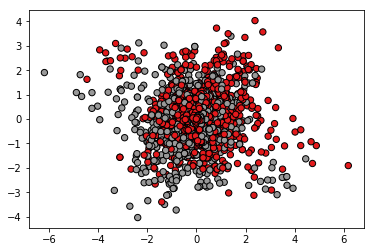

In [22]:
SciKitModel.display(w_l)
print("Evaluating logistic regression")
SciKitModel(linear_model.LogisticRegression(solver='lbfgs')).evaluate(w_l)
SciKitModel(linear_model.LogisticRegression(solver='lbfgs')).evaluate(n_s)


We wouldn't expect logistic regression to be very good here because of high dimensionality. Let's look at a few others.

In [0]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
print("Evaluating svm classification")
pipeline = make_pipeline(Normalizer(copy=False), svm.SVC(gamma='scale'))
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)



Evaluating svm classification


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:

pipeline = make_pipeline(TruncatedSVD(10), Normalizer(copy=False), svm.SVC(gamma='scale'))
print("Evaluating svm + svd classification")
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  

pipeline = make_pipeline(MLPClassifier(solver='lbfgs', activation='tanh', hidden_layer_sizes=(100,100,100), random_state=1))
print("Evaluating dnn classification")
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)

In [0]:
pipeline = make_pipeline(MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20,20,20), random_state=1))
print("Evaluating dnn classification")
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

parameters = {'solver': ['lbfgs'],  'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
pipeline = make_pipeline(StandardScaler(with_mean=False), GridSearchCV(MLPClassifier(), parameters, n_jobs=-1))
print("Evaluating dnn classification")
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)

In [0]:
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0))
                         
print("Evaluating random forest classification")
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)


In [0]:
from sklearn.naive_bayes import MultinomialNB
pipeline = make_pipeline(MultinomialNB())
                         
print("Evaluating naive bayes classification")
SciKitModel(pipeline).evaluate(w_l)
SciKitModel(pipeline).evaluate(n_s)

In [0]:
! pip install tensorflow_ranking
import tensorflow as tf
import tensorflow_ranking as tfr

tf.enable_eager_execution()
tf.executing_eagerly()




In [0]:
def calc_win_rates(records):
  win_rates = {}
  
  for team_a in records:
    a_record = []
    for i in records[team_a]:
      for v in records[team_a][i]:
         a_record.append(v)
    if len(a_record) > 0:
      win_rates[team_a] = sum(a_record)/len(a_record)
    else:
      win_rates[team_a] = 0
  return win_rates

def to_tensor_test(records, test):
  win_rates = calc_win_rates(records)
  id_map = {i:str(x+1) for x, i in enumerate(records.keys())}
  def inner_generator():
    #Generate training data by choosing two teams that have played together, removing a result to treat as label and concatenating team records
    for team_a in test:

      for team_b in test[team_a]:
        if team_b > team_a:
          for game_i in range(len(test[team_a][team_b])):

            result = 1 if test[team_a][team_b][game_i] > 0 else 0
            a_win_rate = 0
            b_win_rate = 0

            a_win_rate = win_rates[team_a]
            b_win_rate = win_rates[team_b]

            output = {}
            for k in range(len(records.keys())):
              output[str(k+1)] = np.zeros([2, 1], dtype=np.float32)
              output[str(k+1)][0,0] = a_win_rate
              output[str(k+1)][1,0] = b_win_rate


            for i in records[team_a]:
              output[id_map[i]][0,0] = sum(records[team_a][i])/len(records[team_a][i])
            for i in records[team_b]:
              output[id_map[i]][1] = sum(records[team_b][i])/len(records[team_b][i])
            yield output, [result, 1 - result]
  return inner_generator   
def to_tensor(records, train=None):
  win_rates = None
  id_map = {i:str(x+1) for x, i in enumerate(records.keys())}
  def inner_generator():
    #Generate training data by choosing two teams that have played together, removing a result to treat as label and concatenating team records
    for team_a in records:

      for team_b in records[team_a]:
        if team_b > team_a:
          assert len(records[team_a][team_b]) == len(records[team_b][team_a])
          assert sum(records[team_a][team_b]) == -1 * sum(records[team_b][team_a])

          #Now mask a game
          for game_i in range(len(records[team_a][team_b])):
            masked = [records[team_a][team_b][x] for x in range(len(records[team_a][team_b])) if x != game_i]
            masked_average = 0
            if masked != []:
              masked_average = sum(masked)/len(masked)
            result = 1 if records[team_a][team_b][game_i] > 0 else 0
            a_win_rate = 0
            b_win_rate = 0

            a_record = []
            for i in records[team_a]:
              for j, v in enumerate(records[team_a][i]):
                if not(i == team_b and j == game_i):
                  a_record.append(v)

            b_record = []
            for i in records[team_b]:
              for j, v in enumerate(records[team_b][i]):
                if not (i == team_a and j == game_i):
                  b_record.append(v)
            if len(a_record) > 0:

              a_win_rate = sum(a_record)/len(a_record)
            if len(b_record) > 0:

              b_win_rate = sum(b_record)/len(b_record)

            output = {}
            for k in range(len(records.keys())):
              output[str(k+1)] = np.zeros([2, 1], dtype=np.float32)
              output[str(k+1)][0,0] = a_win_rate
              output[str(k+1)][1,0] = b_win_rate


            x = id_map[team_b]

            for i in records[team_a]:
              output[id_map[i]][0,0] = sum(records[team_a][i])/len(records[team_a][i])
            output[id_map[team_b]][0,0] = masked_average
            for i in records[team_b]:
              output[id_map[i]][1] = sum(records[team_b][i])/len(records[team_b][i])
            output[id_map[team_a]][1,0] = -1 * masked_average
            yield output, [result, 1 - result]
 
  return inner_generator

def from_records(records):
  train_dataset = tf.data.Dataset.from_generator(
      to_tensor(records),
      output_types=(
          {str(k): tf.float32 for k in range(1,len(records.keys())+1)},
          tf.float32
      ),
      output_shapes=(
          {str(k): tf.TensorShape([2, 1])
            for k in range(1,len(records.keys())+ 1)},
          tf.TensorShape([2])
      )
  )

  train_dataset = train_dataset.shuffle(1000).repeat().batch(32)
  return train_dataset.make_one_shot_iterator().get_next()


def from_records_test(records, test):
  train_dataset = tf.data.Dataset.from_generator(
      to_tensor_test(records, test),
      output_types=(
          {str(k): tf.float32 for k in range(1,len(records.keys())+1)},
          tf.float32
      ),
      output_shapes=(
          {str(k): tf.TensorShape([2, 1])
            for k in range(1,len(records.keys())+ 1)},
          tf.TensorShape([2])
      )
  )

  train_dataset = train_dataset.shuffle(1000).repeat().batch(32)
  return train_dataset.make_one_shot_iterator().get_next()



In [0]:
to_tensor(w_l_train)
to_tensor_test(w_l_train, w_l_test)

In [0]:
def example_feature_columns():
  """Returns the example feature columns."""
  feature_names = [
      "%d" % (i + 1) for i in range(0, _NUM_FEATURES)
  ]
  return {
      name: tf.feature_column.numeric_column(
          name, shape=(1,), default_value=0.0) for name in feature_names
  }

def make_score_fn():
  """Returns a scoring function to build `EstimatorSpec`."""

  def _score_fn(context_features, group_features, mode, params, config):
    """Defines the network to score a documents."""
    del params
    del config
   
  
    # Define input layer.
    example_input = [
        tf.layers.flatten(group_features[name])
        for name in sorted(example_feature_columns())
    ]
    input_layer = tf.concat(example_input, 1)

    cur_layer = input_layer
    for i, layer_width in enumerate(int(d) for d in _HIDDEN_LAYER_DIMS):
      cur_layer = tf.layers.dense(
          cur_layer,
          units=layer_width,
          activation="tanh")
      cur_layer = tf.layers.batch_normalization(cur_layer)
      cur_layer = tf.nn.relu(cur_layer)

    logits = tf.layers.dense(cur_layer, units=1)
    return logits

  return _score_fn

In [0]:
def eval_metric_fns():
  """Returns a dict from name to metric functions.

  This can be customized as follows. Care must be taken when handling padded
  lists.

  def _auc(labels, predictions, features):
    is_label_valid = tf_reshape(tf.greater_equal(labels, 0.), [-1, 1])
    clean_labels = tf.boolean_mask(tf.reshape(labels, [-1, 1], is_label_valid)
    clean_pred = tf.boolean_maks(tf.reshape(predictions, [-1, 1], is_label_valid)
    return tf.metrics.auc(clean_labels, tf.sigmoid(clean_pred), ...)
  metric_fns["auc"] = _auc

  Returns:
    A dict mapping from metric name to a metric function with above signature.
  """
  metric_fns = {}
  metric_fns.update({
      "accuracy" : tfr.metrics.make_ranking_metric_fn(
          tfr.metrics.RankingMetricKey.ORDERED_PAIR_ACCURACY)
  
  })

  return metric_fns

In [0]:
def get_estimator(hparams):
  """Create a ranking estimator.

  Args:
    hparams: (tf.contrib.training.HParams) a hyperparameters object.

  Returns:
    tf.learn `Estimator`.
  """
  def _train_op_fn(loss):
    """Defines train op used in ranking head."""
    return tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=hparams.learning_rate,
        optimizer="Adagrad")

  ranking_head = tfr.head.create_ranking_head(
      loss_fn=tfr.losses.make_loss_fn("softmax_loss"),
      eval_metric_fns=eval_metric_fns(),
      train_op_fn=_train_op_fn)

  return tf.estimator.Estimator(
      model_fn=tfr.model.make_groupwise_ranking_fn(
          group_score_fn=make_score_fn(),
          group_size=1,
          transform_fn=None,
          ranking_head=ranking_head),
      params=hparams)

In [0]:
hparams = tf.contrib.training.HParams(learning_rate=0.05)
ranker = get_estimator(hparams)


In [0]:
p = .1
def train_test_split(games):
  random.shuffle(games)
  test = games[:int(p * len(games))]
  train = games[int(p * len(games)):]
  return train,test

train, test = train_test_split(games)
w_l_train, n_s_train = games_to_adjacency(train)
w_l_test, n_s_test = games_to_adjacency(test)

for a in w_l:
  if a not in w_l_train:
    w_l_train[a] = []
    n_s_train[a] = []
  if a not in w_l_test:
    w_l_test[a] = []
    n_s_test[a] = []

In [0]:



_NUM_FEATURES = len(w_l_train.keys())
_HIDDEN_LAYER_DIMS=["60", "5"]
hparams = tf.contrib.training.HParams(learning_rate=0.05)
ranker = get_estimator(hparams)
ranker.train(input_fn=lambda: from_records(n_s_train), steps=100)

In [0]:

ranker.evaluate(input_fn=lambda: from_records_test(n_s_train, n_s_test), steps=100)

In [0]:
predictions = ranker.predict(input_fn=lambda: from_records(w_l))
for p in predictions:
  print(p)

In [0]:
print(list(predictions))